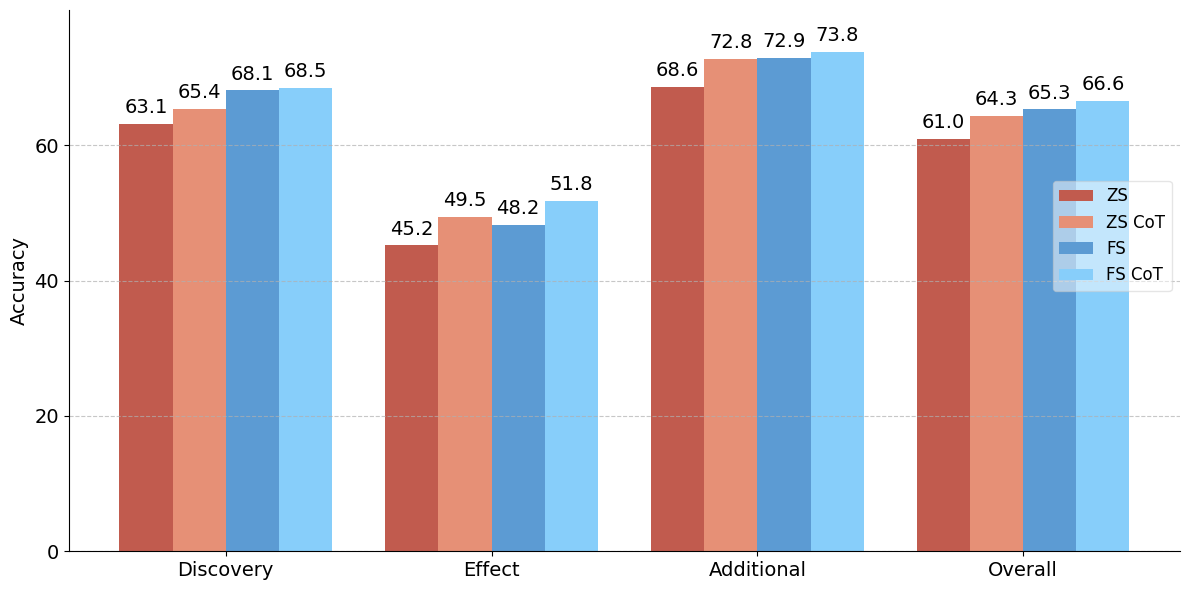

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
df = pd.read_json('eval_result_seed_42_sample_num_500.json')
df_gpt = pd.read_json('eval_result_seed_42_sample_num_100.json')
df = pd.concat([df, df_gpt])
model_list =['meta-llama/Meta-Llama-3.1-8B-Instruct',
       'meta-llama/Meta-Llama-3.1-70B-Instruct',
       'meta-llama/Meta-Llama-3-70B-Instruct', 'meta-llama/Meta-Llama-3-8B-Instruct',
       'gpt-3.5-turbo', 
       'mistralai/Mistral-7B-Instruct-v0.3',
       'mistralai/Mixtral-8x7B-Instruct-v0.1',
       'gpt-4o']

df = df[df['model_name'].isin(model_list)]

dataset_mapping = {
    'Discovery': ['copa', 'e_care', 'corr2cause','pain'],
    'Effect': ['cladder', 'crab'],
    'Additional': ['crass', 'moca', 'tram']
}

# Function to categorize datasets
def categorize_dataset(dataset):
    for category, datasets in dataset_mapping.items():
        if dataset in datasets:
            return category
    return 'Unknown'

# Add category column
df['category'] = df['dataset_name'].apply(categorize_dataset)

# Create labels for the plot
df['label'] = np.where(df['few_shot_flag'],
                       np.where(df['direct_io_flag'], 'FS', 'FS CoT'),
                       np.where(df['direct_io_flag'], 'ZS', 'ZS CoT'))

# Group by category and label, and calculate mean accuracy
grouped = df.groupby(['category', 'label'])['accuracy'].mean().unstack()

# Add 'Overall' category
overall = df.groupby('label')['accuracy'].mean()
grouped.loc['Overall'] = overall

# Order of categories
category_order = ['Discovery', 'Effect', 'Additional', 'Overall']
grouped = grouped.reindex(category_order)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar and the positions of the bars
width = 0.2
x = np.arange(len(grouped.index))

# Define colors matching the image
colors = ['#C15B4E', '#E69076', '#5C9BD3', '#87CEFA']

# Plot bars for each label
for i, label in enumerate(['ZS', 'ZS CoT', 'FS', 'FS CoT']):
    ax.bar(x + (i-1.5)*width, grouped[label]*100, width, label=label, color=colors[i])

# Customize the plot
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(grouped.index, fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.7), ncol=1, fontsize=12, framealpha=0.5)


# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal dotted lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of each bar with one decimal place
for i in x:
    for j, col in enumerate(['ZS', 'ZS CoT', 'FS', 'FS CoT']):
        value = grouped[col].iloc[i]
        # Adjust the value by adding a small offset above the bar
        ax.text(i + (j-1.5)*width, value * 100 + 1, f'{value*100:.1f}', 
                ha='center', va='bottom', fontsize=14)

# Set y-axis limit and ticks
ax.set_ylim(0, 80)
ax.set_yticks(range(0, 75, 20))

# Ensure consistent font sizes across all text elements
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()



/tmp/ipykernel_1654611/4145006037.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set2')(np.linspace(0, 1, len(models)))


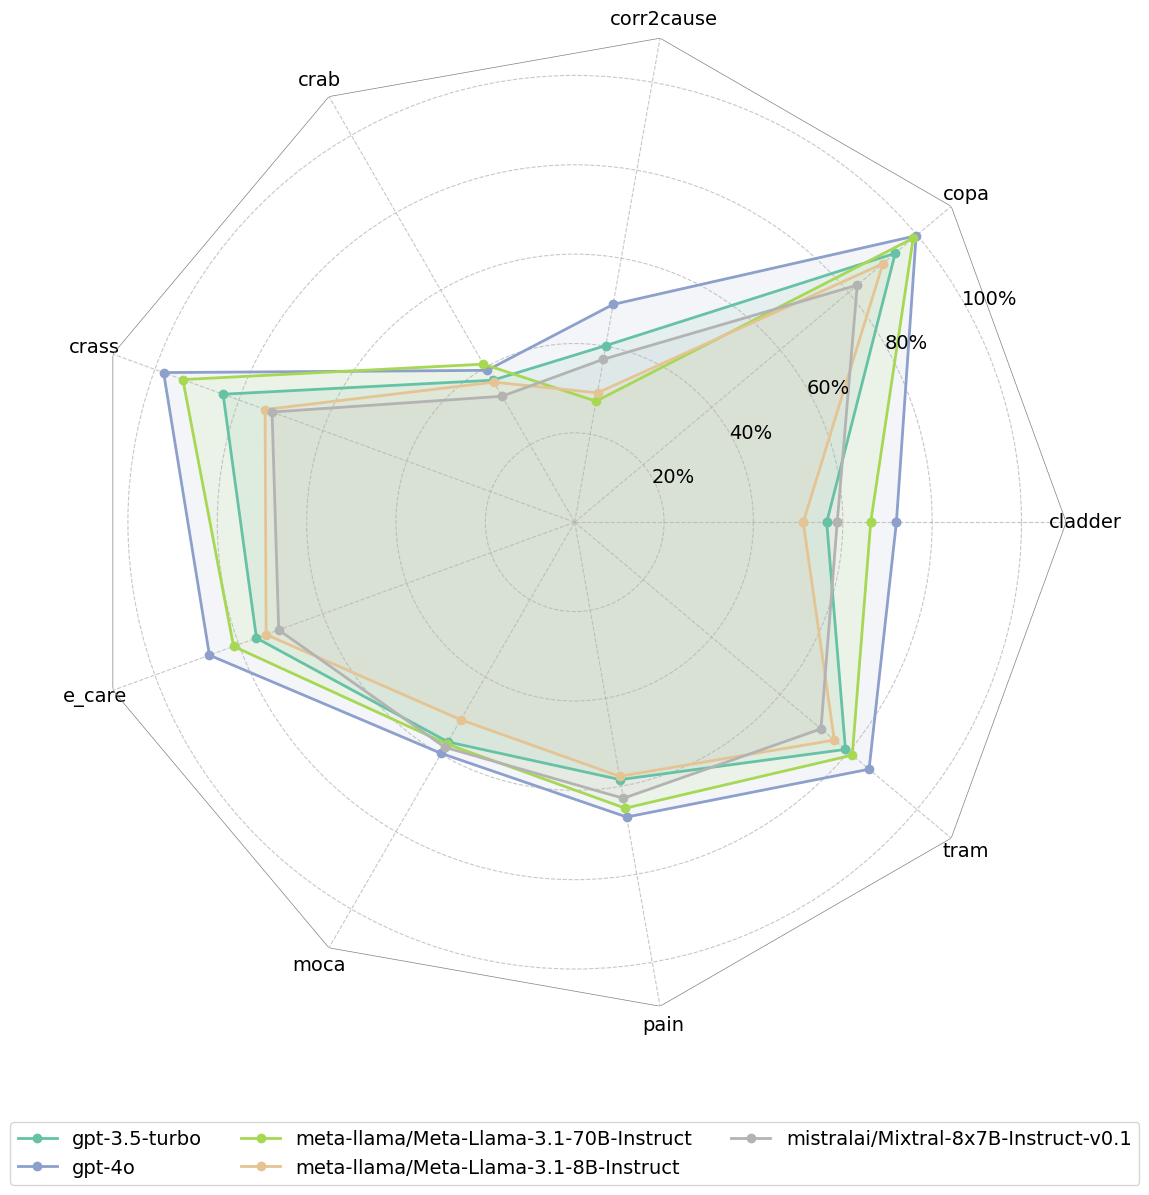

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据（假设文件存在）
df = pd.read_json('eval_result_seed_42_sample_num_500.json')
df_gpt = pd.read_json('eval_result_seed_42_sample_num_100.json')
df = pd.concat([df, df_gpt])

model_list = [
    'meta-llama/Meta-Llama-3.1-8B-Instruct',
    'meta-llama/Meta-Llama-3.1-70B-Instruct',
    #'meta-llama/Meta-Llama-3-70B-Instruct',
    #'meta-llama/Meta-Llama-3-8B-Instruct',
    'gpt-3.5-turbo',
    #'mistralai/Mistral-7B-Instruct-v0.3',
    'mistralai/Mixtral-8x7B-Instruct-v0.1',
    'gpt-4o'
]

df = df[df['model_name'].isin(model_list)]

# 计算每个模型在每个数据集上的平均准确率
mean_accuracy = df.groupby(['model_name', 'dataset_name'])['accuracy'].mean().unstack()

# 准备雷达图的数据
datasets = mean_accuracy.columns
models = mean_accuracy.index
angles = np.linspace(0, 2*np.pi, len(datasets), endpoint=False)

# 闭合雷达图
values = mean_accuracy.values
values = np.concatenate((values, values[:,[0]]), axis=1)
angles = np.concatenate((angles, [angles[0]]))

# 创建椭圆形雷达图
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='polar')

# 颜色映射
colors = plt.cm.get_cmap('Set2')(np.linspace(0, 1, len(models)))

# 绘制额外的外圈
ax.plot(angles, [1.1]*len(angles), color='gray', linewidth=0.5)

for i, model in enumerate(models):
    ax.plot(angles, values[i], 'o-', linewidth=2, label=model, color=colors[i])
    ax.fill(angles, values[i], alpha=0.1, color=colors[i])

# 设置雷达图的属性
ax.set_thetagrids(angles[:-1] * 180/np.pi, datasets, fontsize=14)
ax.set_ylim(0, 1.1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([])  # 移除默认的标签
ax.set_rlabel_position(0)

# 手动添加百分比标签
for y in [0.2, 0.4, 0.6, 0.8, 1.0]:
    ax.text(np.pi/6, y, f'{int(y*100)}%', ha='left', va='center', fontsize=14)

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.7)

# 设置标题
#plt.title("Figure 1: A brief overview of models' performance on TimeBench.", y=1.08, fontsize=18, fontweight='bold')
ax.spines['polar'].set_visible(False)
# 调整图例位置和样式
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=3, fontsize=14)

# 调整图形为椭圆形
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_size_inches(16, 12)

plt.tight_layout()
plt.show()

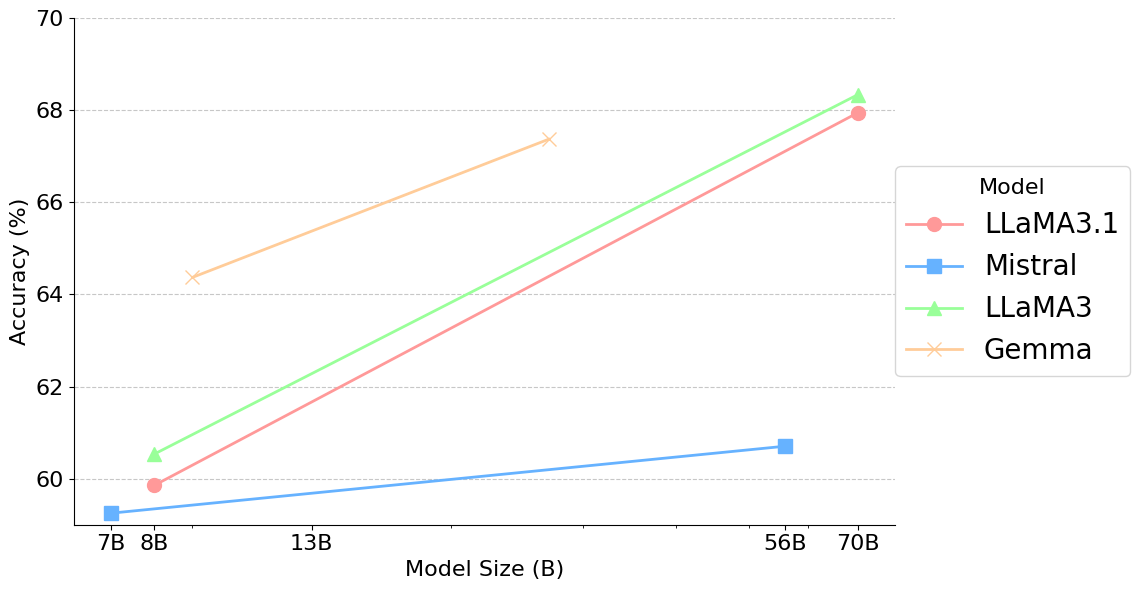

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_json('eval_result_seed_42_sample_num_500.json')
df_gpt = pd.read_json('eval_result_seed_42_sample_num_100.json')
df = pd.concat([df, df_gpt])

# 定义模型组和它们的大小
model_groups = {
    'LLaMA3.1': {'meta-llama/Meta-Llama-3.1-8B-Instruct': 8, 'meta-llama/Meta-Llama-3.1-70B-Instruct': 70},
    'Mistral': {'mistralai/Mistral-7B-Instruct-v0.3': 7, 'mistralai/Mixtral-8x7B-Instruct-v0.1': 56},
    'LLaMA3': {'meta-llama/Meta-Llama-3-8B-Instruct': 8, 'meta-llama/Meta-Llama-3-70B-Instruct': 70},
    "Gemma": {"google/gemma-2-27b-it": 27, "google/gemma-2-9b-it": 9},
}

# 设置图表
fig, ax = plt.subplots(figsize=(12, 6))

# 每个模型组的颜色和标记
styles = [
    {'color': '#FF9999', 'marker': 'o'},
    {'color': '#66B2FF', 'marker': 's'},
    {'color': '#99FF99', 'marker': '^'},
    {'color': '#FFCC99', 'marker': 'x'}
]

# 绘制每个模型组
for (group, models), style in zip(model_groups.items(), styles):
    sizes = []
    accuracies = []
    for model, size in models.items():
        accuracy = df[df['model_name'] == model]['accuracy'].mean() * 100
        sizes.append(size)
        accuracies.append(accuracy)
    ax.plot(sizes, accuracies, '-', label=group, color=style['color'], marker=style['marker'], markersize=10, linewidth=2)

# 设置 x 轴为对数刻度
ax.set_xscale('log')

# 自定义 x 轴标签
ax.set_xticks([7, 8, 13, 56, 70])
ax.set_xticklabels(['7B', '8B', '13B', '56B', '70B'], fontsize=16)

# 自定义图表
ax.set_xlabel('Model Size (B)', fontsize=16)
ax.set_ylabel('Accuracy (%)', fontsize=16)
#ax.set_title('Scaling Effect of Model Size and Overall Temporal Reasoning Performance', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# 移除顶部和右边的边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=16)
# 设置 y 轴范围
ax.set_ylim(59, 70)

# 调整legend
legend = ax.legend(title='Model', loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0., fontsize=20)
plt.setp(legend.get_title(), fontsize=16)

# 调整布局以适应legend
plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.show()


In [3]:
df.columns 

Index(['model_name', 'accuracy', 'seed', 'sample_size', 'few_shot_flag',
       'direct_io_flag', 'dataset_name'],
      dtype='object')

In [16]:
import pandas as pd

df = pd.read_json('eval_result_seed_42_sample_num_500.json')


In [17]:
model_list =['meta-llama/Meta-Llama-3.1-8B-Instruct',
       'meta-llama/Meta-Llama-3.1-70B-Instruct',
       'meta-llama/Meta-Llama-3-70B-Instruct',
         'meta-llama/Meta-Llama-3-8B-Instruct',
         'mistralai/Mistral-7B-Instruct-v0.3',
       'mistralai/Mixtral-8x7B-Instruct-v0.1',
       'gpt-3.5-turbo']
df = df[df["model_name"].isin(model_list)]

result = df.groupby(['dataset_name', 'model_name']).count().reset_index()
result[result["seed"]!=4]


,dataset_name,model_name,accuracy,seed,sample_size,few_shot_flag,direct_io_flag


In [30]:
import pandas as pd

df = pd.read_json('eval_result_seed_42_sample_num_100.json')

df 
result = df.groupby(['dataset_name', 'model_name']).count().reset_index()
result


,dataset_name,model_name,accuracy,seed,sample_size,few_shot_flag,direct_io_flag
0,cladder,claude-3-5-sonnet-20240620,4,4,4,4,4
1,cladder,google/gemma-2-27b-it,4,4,4,4,4
2,cladder,google/gemma-2-9b-it,3,3,3,3,3
3,cladder,gpt-4o,4,4,4,4,4
4,copa,claude-3-5-sonnet-20240620,4,4,4,4,4
5,copa,gpt-4o,4,4,4,4,4
6,corr2cause,gpt-4o,4,4,4,4,4
7,crab,gpt-4o,4,4,4,4,4
8,crass,claude-3-5-sonnet-20240620,1,1,1,1,1
9,crass,gpt-4o,4,4,4,4,4


In [5]:
import pandas as pd

df = pd.read_json('eval_result_seed_42_sample_num_500.json')
order_list = ["copa","pain","e_care","corr2cause","cladder","crab","crass","moca","tram"]

model_name ="google/gemma-2-9b-it"
df = df[df["model_name"]==model_name]
dirct_io_list = []
dirct_io_cot_list = []
few_shot_list = []
few_shot_cot_list = []

for dataset_name in order_list:
    df_temp = df[df["dataset_name"]==dataset_name]
    direct_io_reult = df_temp[(df_temp["direct_io_flag"]==True)&(df_temp["few_shot_flag"]==False)]
    direct_io_cot_reult = df_temp[(df_temp["direct_io_flag"]==True)&(df_temp["few_shot_flag"]==True)]
    few_shot_reult = df_temp[(df_temp["direct_io_flag"]==False)&(df_temp["few_shot_flag"]==False)]
    few_shot_cot_reult = df_temp[(df_temp["direct_io_flag"]==False)&(df_temp["few_shot_flag"]==True)]
    dirct_io_list.append(direct_io_reult["accuracy"].values[0])
    dirct_io_cot_list.append(direct_io_cot_reult["accuracy"].values[0])
    few_shot_list.append(few_shot_reult["accuracy"].values[0])
    few_shot_cot_list.append(few_shot_cot_reult["accuracy"].values[0])

def format_accuracy(accuracy):
    if np.isnan(accuracy):
        return '-'
    return f'{accuracy * 100:.1f}'
import numpy as np
direct_io_few_shot = ' & '.join([f'{format_accuracy(dirct_io_list[i])}/{format_accuracy(few_shot_list[i])}' for i in range(len(order_list))])
direct_io_few_shot_line = f"Gemma-2-9b & {direct_io_few_shot}\\\\"

# Format the CoT line
cot_line = ' & '.join([f'{format_accuracy(dirct_io_cot_list[i])}/{format_accuracy(few_shot_cot_list[i])}' for i in range(len(order_list))])
cot_line = f" \\qquad + CoT & {cot_line}\\\\"
print(direct_io_few_shot_line)
print(cot_line)

Gemma-2-9b & 91.2/82.8 & 67.0/71.0 & 69.4/74.8 & 31.0/29.8 & 56.8/55.2 & 45.2/42.6 & 76.7/75.0 & 57.6/59.7 & 79.2/78.4\\
 \qquad + CoT & 96.0/96.0 & 77.0/51.0 & 80.6/82.0 & 37.6/40.0 & 56.0/55.0 & 40.2/37.4 & 76.7/85.0 & 63.2/59.7 & 83.2/81.4\\
